# Exercise - functional API

Use the CIFAR-10 data with images padded onto a 60x60 mask (the code for this is available in the notebook for this exercise) to solve this exercise.

1. Build a CNN to solve the task *using the functional API*. Note that the images are relatively large now (compared to the slides), so you may want to apply an additional pooling layer for downscaling.
1. Build a spatial transformer network to solve the task (you need to use the functional API to some extent; see the slides). Consider using default zoom for a good prior (i.e. ca. 50% "zoom"). Preferably this should have roughly the same number of parameters as your model in **1.**. Is it better?
1. Visualize some of the images after your spatial transformer transforms them. Are they transformed in a sensible way?

**Note**: Be sure to place the layers.py file in the same folder as this file to import the BilinearInterpolation layer.

**Note**: You may want to use:
1. To see a list of pre-trained models you may use: https://www.tensorflow.org/guide/keras/functional

**See slides for more details!**

# Note

The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

https://www.tensorflow.org/guide/keras/functional#introduction

# Setup code - no need to change anything

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


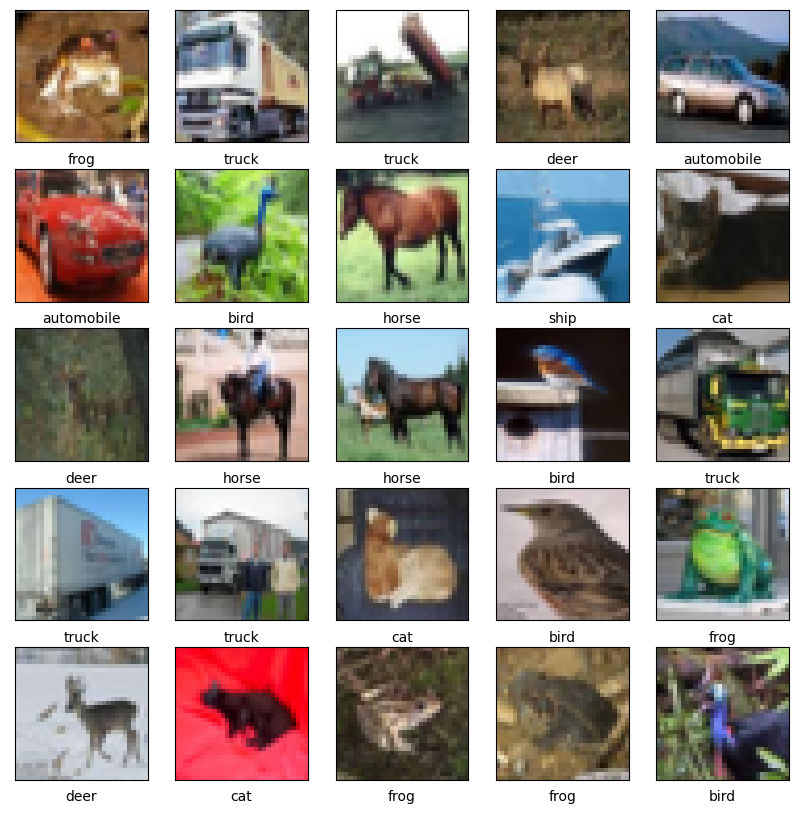

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from layers import BilinearInterpolation

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1) # to change from array of arrays format
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [2]:
enlarged_shape = (60, 60, 3)
diff_x = enlarged_shape[1] - 32
diff_y = enlarged_shape[0] - 32

def enlargen_images(images):
    images_mod = []
    for x in images:
        mask = np.zeros(enlarged_shape)
        offset_x, offset_y = np.random.choice(range(diff_x)), np.random.choice(range(diff_y))
        mask[offset_y:(offset_y + 32), offset_x:(offset_x + 32), :] = x
        images_mod.append(mask)

    return np.array(images_mod)

train_images = enlargen_images(train_images)
test_images =  enlargen_images(test_images)

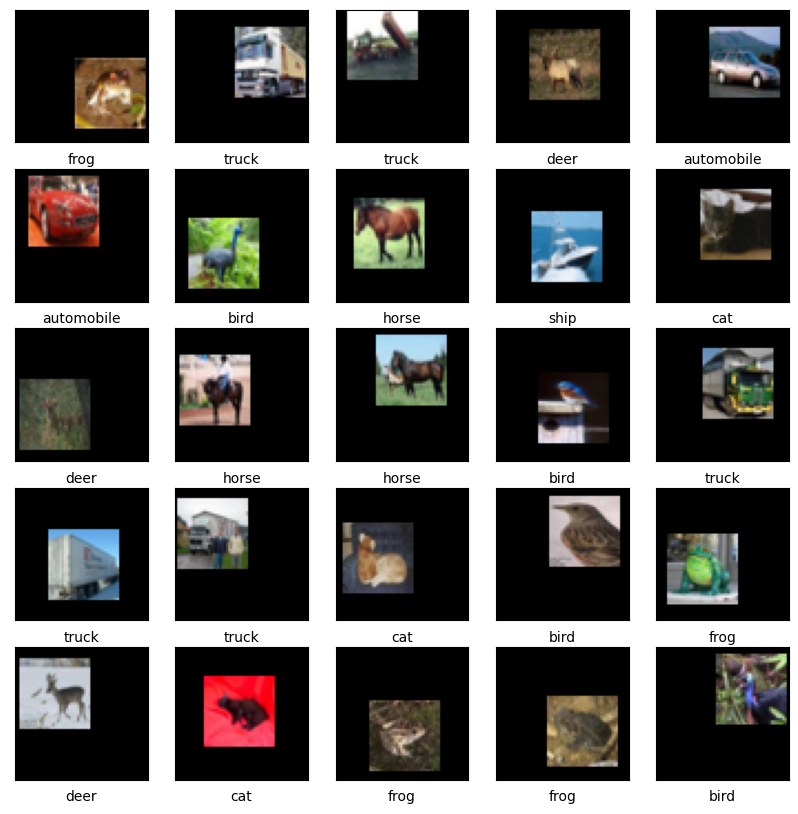

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [4]:
model_sequential_api = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(60, 60, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
    ])
model_sequential_api.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
model_sequential_api.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

# Exercise 1

Build a CNN to solve the task *using the functional API*. Note that the images are relatively large now (compared to the slides), so you may want to apply an additional pooling layer for downscaling.

**Hint**: Try to re-implement the above neural network using the functional API.

In [5]:
# Define the input layer
input_layer = tf.keras.layers.Input((60, 60, 3))
# ..next define the first conv-layer **on** the input layer
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

model_functional_api = tf.keras.models.Model(input_layer, x)
model_functional_api.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
model_functional_api.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        36928 

In [6]:
hist = model_functional_api.fit(train_images, train_labels,
                                validation_data=(test_images, test_labels), batch_size=8,epochs=1, verbose=1)

6250/6250 [==============================] - 69s 10ms/step - loss: 1.8055 - accuracy: 0.3136 - val_loss: 1.6160 - val_accuracy: 0.4001


# Exercise 2

Build a spatial transformer network to solve the task (you need to use the functional API to some extent; see the slides). Consider using default zoom for a good prior (i.e. ca. 50% "zoom"). Preferably this should have roughly the same number of parameters as your model in **1.**. Is it better?

In [13]:
default_zoom=0.5
def initialize_weights(input_nodes: int, default_zoom: float):
    biases = np.zeros((2, 3), dtype='float32')
    biases[0, 0] = default_zoom
    biases[1, 1] = default_zoom
    weights = np.zeros((input_nodes, 6), dtype='float32')
    
    return [weights, biases.flatten()]

In [17]:
loc_input_layer = tf.keras.Input(shape=(60, 60, 3))

x = tf.keras.layers.Conv2D(8, kernel_size=7)(loc_input_layer)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Conv2D(10, kernel_size=5)(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x) # 32 must match the below function call
x = tf.keras.layers.Dense(6, activation='linear',weights=initialize_weights(32, default_zoom))(x)

x = BilinearInterpolation((32, 32))([loc_input_layer, x]) # Output (32,32,3)
print(x)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), name='bilinear_interpolation_2/Reshape_9:0', description="created by layer 'bilinear_interpolation_2'")


In [20]:
cnn = tf.keras.layers.Conv2D(10, kernel_size=5)(x)

cnn = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn=tf.keras.layers.ReLU()(cnn)
cnn=tf.keras.layers.Conv2D(20, kernel_size=5)(cnn)
cnn=tf.keras.layers.SpatialDropout2D(0.2)(cnn)
cnn=tf.keras.layers.MaxPool2D(pool_size=(2, 2))(cnn)
cnn=tf.keras.layers.ReLU()(cnn)
cnn=tf.keras.layers.Flatten()(cnn)
cnn=tf.keras.layers.Dense(50, activation='relu')(cnn)
cnn=tf.keras.layers.Dropout(0.2)(cnn)
out = tf.keras.layers.Dense(10, activation='softmax')(cnn)
 


In [21]:
spatial_transform = tf.keras.models.Model(
    inputs=loc_input_layer, outputs=out, name='spatial_transformer',
)
spatial_transform.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'],)
spatial_transform.summary()

Model: "spatial_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 60, 60, 3)]  0           []                               
                                                                                                  
 conv2d_19 (Conv2D)             (None, 54, 54, 8)    1184        ['input_7[0][0]']                
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 27, 27, 8)   0           ['conv2d_19[0][0]']              
 )                                                                                                
                                                                                                  
 re_lu_10 (ReLU)                (None, 27, 27, 8)    0           ['max_pooling2d

In [22]:
hist_stn = spatial_transform.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=11, verbose=1)

Epoch 1/11
1563/1563 [==============================] - 38s 23ms/step - loss: 2.2178 - accuracy: 0.1477 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 2/11
1563/1563 [==============================] - 34s 22ms/step - loss: 2.3029 - accuracy: 0.0998 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 3/11
1563/1563 [==============================] - 38s 24ms/step - loss: 2.3029 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/11
1563/1563 [==============================] - 41s 26ms/step - loss: 2.3028 - accuracy: 0.0994 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 5/11
1563/1563 [==============================] - 43s 28ms/step - loss: 2.3029 - accuracy: 0.0969 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/11
1563/1563 [==============================] - 50s 32ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/11
1563/1563 [==============================] - 50s 32ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3026 -

# Exercise 3

Visualize some of the images after your spatial transformer transforms them. Are they transformed in a sensible way?

In [ ]:
# an example of how to do it
idx = 0

enlarged_im = train_images[idx]
transformed_im = stn_model.get_layer('spatial_transformer')(train_images[idx:(idx + 1)]).numpy()[0]

plt.imshow(enlarged_im); plt.show()
plt.imshow(transformed_im); plt.show()